In [3]:
from math import pi, sqrt, floor, ceil

from PIL import Image
from PIL.ImageFile import ImageFile
from skimage.draw import line_nd
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from IPython.display import clear_output
import ipywidgets

In [ ]:
def load_bitmap(filename: str) -> ImageFile:
    image = Image.open("./obrazy/" + filename)
    return image

def find_coords_inside_image(
    pixels: NDArray,
    im_size: tuple,
) -> tuple:
    # 3. b) wyznacz linie przejścia tylko przez obraz (wersja z wyszukiwaniem przez połowienie)
    width = im_size[0]
    height = im_size[1]

    line_start = 0
    line_end = pixels.shape[1] - 1
    mid_line_point = (line_start + line_end) // 2

    pixel_x, pixel_y = pixels[:, mid_line_point]
    while not (0 <= pixel_x < width and 0 <= pixel_y < height):
        return (-1, -1)

    end = mid_line_point
    # print(f"1. {line_start} : {end}")
    while line_start != end:
        mid_point = (line_start + end) // 2
        pixel_x, pixel_y = pixels[:, mid_point]
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            end = mid_point
        else:
            line_start = mid_point + 1
        # print(f"1. {line_start} : {end}")

    start = mid_line_point
    # print(f"2. {start} : {line_end}")
    while start != line_end:
        mid_point = ((start + line_end) // 2) + 1
        pixel_x, pixel_y = pixels[:, mid_point]
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            start = mid_point
        else:
            line_end = mid_point - 1

    return (line_start, line_end)

def calculate_scan_rays(
    image_filename: str,
    scans_count: int,
    alfa_step: float,
    detectors_count: int,
    detectors_angular_aperture: float,
    create_optional_partial_images: bool = False,
    create_optional_full_image: bool = False,
) -> NDArray:
# 5.3% time
    image = load_bitmap(image_filename)
    image.load()
    im_size = image.size
    image.close()

    # 1. Opisz okrąg na obrazie
    diagonal_length = sqrt(pow(im_size[0], 2) + pow(im_size[1], 2))
    radius = diagonal_length / 2

    im_left_x = -im_size[0] // 2
    im_top_y = -im_size[1] // 2

    # 2. Wyznacz położenie n emiterów i n detektorów na okręgu

    # Arrays of all emitters and detectors positions set to (radius, radius)
    emitters_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )
    detectors_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )

    # Arrays of all emitters angles set to 0 rad
    emitters_angles = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # Arrays of all detectors angles set to pi rad
    detectors_angles = np.full((scans_count, detectors_count), pi, dtype=np.float64)

    # Array of angle differences between scans
    scan_start_angles = np.arange(
        0, scans_count * alfa_step, alfa_step, dtype=np.float64
    )

    # Update emitters and detectors angles to include difference in angle between scans
    emitters_angles += scan_start_angles[:, np.newaxis]
    detectors_angles += scan_start_angles[:, np.newaxis]

    # Array of angle differences between detectors/emitters
    angles_dif = np.linspace(
        -detectors_angular_aperture / 2,
        detectors_angular_aperture / 2,
        detectors_count,
        dtype=np.float64,
    )

    # Update emitters and detectors angles to include difference in angle between detectors/emitters
    emitters_angles -= angles_dif
    detectors_angles += angles_dif

    # Calculate cordinates of emitters and detectors
    emitters_positions_x = np.cos(emitters_angles)
    emitters_positions_y = np.sin(emitters_angles)
    emitters_positions_xy = np.stack(
        (emitters_positions_x, emitters_positions_y), axis=2, dtype=np.float64
    )
    emitters_positions *= emitters_positions_xy

    detectors_positions_x = np.cos(detectors_angles)
    detectors_positions_y = np.sin(detectors_angles)
    detectors_positions_xy = np.stack(
        (detectors_positions_x, detectors_positions_y), axis=2, dtype=np.float64
    )
    detectors_positions_xy = np.stack(
        (np.cos(detectors_angles), np.sin(detectors_angles)), axis=2, dtype=np.float64
    )
    detectors_positions *= detectors_positions_xy

    all_scans_rays = np.empty((scans_count, detectors_count), dtype=np.object_)
    for scan_number in range(scans_count):
        # print(f"Create lines in {scan_number} scan")
        for detector_number in range(detectors_count):
            # 3. Wyznacz linie przejścia
            # 3. a) wyznacz linie przejścia od emiterów do detektorów
            emitter_coords = emitters_positions[scan_number][detector_number]
            detector_coords = detectors_positions[scan_number][detector_number]

# 63% time
            pixels_coords = line_nd(emitter_coords, detector_coords, endpoint=True)

            # Change coordinate system to image coordinate system where point (0,0) means upper left corner of image
# 7.8% time
            pixels_coords -= np.array([im_left_x, im_top_y])[:, np.newaxis]

            # 3. b) wyznacz linie przejścia tylko przez obraz (wersja z wyszukiwaniem przez połowienie)
# 20.7% time
            line_start, line_end = find_coords_inside_image(pixels_coords, im_size)
            if line_start == -1:
                # Alternative way to calculate similiar time requirements
                width = im_size[0]
                height = im_size[1]
                filter = (
                    (0 <= pixels_coords[0, :])
                    & (pixels_coords[0, :] < width)
                    & (0 <= pixels_coords[1, :])
                    & (pixels_coords[1, :] < height)
                )

                all_scans_rays[scan_number][detector_number] = tuple(
                    pixels_coords[:, filter]
                )
            else:
                all_scans_rays[scan_number][detector_number] = tuple(
                    pixels_coords[:, line_start : line_end + 1]
                )

        # Optional partial rays image
        if create_optional_partial_images:
            plt.figure(figsize=(6, 6))
            plt.axis("equal")
            plt.xlim((-floor(radius * 1.1), ceil(radius * 1.1)))
            plt.ylim((ceil(radius * 1.1), -floor(radius * 1.1)))
            x, y = zip(*(emitters_positions[scan_number]))
            plt.plot(x, y, "ro", markersize=2)
            x, y = zip(*(detectors_positions[scan_number]))
            plt.plot(x, y, "go", markersize=2)
            all_ray_pixels_x = []
            all_ray_pixels_y = []
            for ray in all_scans_rays[scan_number]:
                x, y = ray
                all_ray_pixels_x.extend(np.array(x) + im_left_x)
                all_ray_pixels_y.extend(np.array(y) + im_top_y)
            x, y = all_ray_pixels_x, all_ray_pixels_y
            plt.plot(x, y, "bo", markersize=1, alpha=0.1)
            plt.imshow(
                plt.imread(f"obrazy/{image_filename}"),
                extent=(
                    im_left_x,
                    im_left_x + im_size[0],
                    im_top_y + im_size[1],
                    im_top_y,
                ),
            )
            plt.title(f"Rays during scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()

    # Optional full rays image
    if create_optional_full_image:
        plt.figure(figsize=(6,6))
        plt.axis("equal")
        plt.xlim((-floor(radius * 1.1), ceil(radius * 1.1)))
        plt.ylim((ceil(radius * 1.1), -floor(radius * 1.1)))
        all_emitters_pixels_x = []
        all_emitters_pixels_y = []
        for scan_emitters_positions in emitters_positions:
            for emitter_position in scan_emitters_positions:
                x, y = emitter_position
                all_emitters_pixels_x.append(x)
                all_emitters_pixels_y.append(y)
        plt.plot(all_emitters_pixels_x, all_emitters_pixels_y, "go", markersize=2)
        plt.plot(x, y, "ro", markersize=2)
        all_detectors_pixels_x = []
        all_detectors_pixels_y = []
        for scan_detectors_positions in detectors_positions:
            for detector_position in scan_detectors_positions:
                x, y = detector_position
                all_detectors_pixels_x.append(x)
                all_detectors_pixels_y.append(y)
        plt.plot(all_detectors_pixels_x, all_detectors_pixels_y, "go", markersize=2)
        all_ray_pixels_x = []
        all_ray_pixels_y = []
        for scan_rays in all_scans_rays:
            for ray in scan_rays:
                x, y = ray
                all_ray_pixels_x.extend(np.array(x) + im_left_x)
                all_ray_pixels_y.extend(np.array(y) + im_top_y)
        plt.plot(all_ray_pixels_x, all_ray_pixels_y, "bo", markersize=1, alpha=0.1)
        plt.imshow(
            plt.imread(f"obrazy/{image_filename}"),
            extent=(
                im_left_x,
                im_left_x + im_size[0],
                im_top_y + im_size[1],
                im_top_y,
            ),
        )
        plt.title(f"All rays after all scans")
        clear_output(wait=True)
        plt.show()

    return all_scans_rays

def calculate_sinogram(
    image_filename: str,
    all_scans_rays: NDArray,
    has_to_use_sinogram_filter: bool = True,
    has_to_show_intermediate_steps: bool = False
) -> NDArray:
    # Create array for sinogram data
    scans_count, detectors_count = all_scans_rays.shape
    data = np.zeros((scans_count, detectors_count), dtype=np.float64)

    image = load_bitmap(image_filename)
    image.load()
    im_size = image.size
    im_pixels = np.asarray(image, dtype=np.float64)
    image.close()

    im_pixels1 = im_pixels.mean(axis=2)


    if has_to_use_sinogram_filter:
        kernel = np.zeros(21)
        kernel[10] = 1
        numerator = -4/(pi**2)
        for k in range(1,11,2):
            kernel_value = (numerator)/(k**2)
            kernel[k+10] = kernel_value
            kernel[-k+10] = kernel_value

    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):
            if len(all_scans_rays[scan_number, detector_number][0]) == 0:
                data[scan_number, detector_number] = 0
                continue
            ray_matrix = np.zeros(im_size, dtype=np.uint8)
            ray_matrix[all_scans_rays[scan_number, detector_number]] = 1

# 14.5% time
            ray_pixel_number = ray_matrix.sum()

# 81.6% time
            ray_sum = np.sum(ray_matrix * im_pixels1)

            
            data[scan_number, detector_number] = ray_sum / ray_pixel_number
            
        if has_to_use_sinogram_filter:
            data[scan_number] = np.convolve(data[scan_number], kernel, mode="same")

        if has_to_show_intermediate_steps:
            plt.figure(figsize=(6,6))
            plt.imshow(data, cmap="gray")
            plt.title(f"Sinogram after scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()

    # 5. Zwróć sinogram
    return data

def show_sinogram(sinogram: NDArray, scan: int):
    data = np.zeros(sinogram.shape)
    data[:scan] += sinogram[:scan]
    plt.figure(figsize=(6,6))
    plt.imshow(data, cmap="gray")
    plt.title(f"Sinogram after scan nr. {scan}")
    clear_output(wait=True)
    plt.show()

def make_image(
    filename: str,
    all_scans_rays: NDArray,
    sinogram: NDArray,
    has_to_show_intermediate_steps: bool = True
) -> NDArray:
    scans_count, detectors_count = sinogram.shape

    image = load_bitmap(filename)
    im_size = image.size
    image.close()

    images = np.empty((scans_count, im_size[0], im_size[1]))

    image_data = np.zeros(im_size)
    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):
            if len(all_scans_rays[scan_number, detector_number][0]) == 0:
                continue
            ray_matrix = np.zeros(im_size, dtype=np.uint8)
            ray_matrix[all_scans_rays[scan_number, detector_number]] = 1


# 93.4% time
            image_data += ray_matrix * sinogram[scan_number, detector_number]

        if has_to_show_intermediate_steps:
            images[scan_number] = image_data
            plt.figure(figsize=(6,6))
            plt.imshow(image_data, cmap="gray")
            plt.title(f"Image after scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()

    if has_to_show_intermediate_steps:
        return images
    
    return image_data

def show_image(images: NDArray, scan: int):
    plt.figure(figsize=(6,6))
    plt.imshow(images[scan-1], cmap="gray")
    plt.title(f"Image after scan nr. {scan}")
    clear_output(wait=True)
    plt.show()

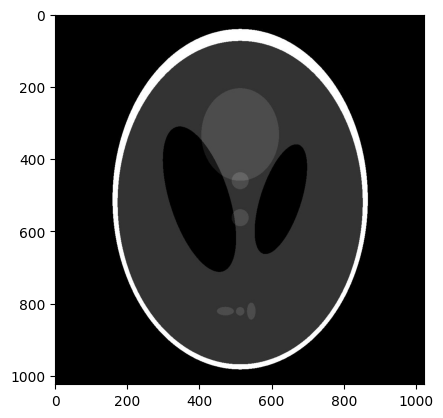

In [77]:
# filename = "Kropka.jpg"
filename = "Shepp_logan.jpg"

scans_count = 180
# scans_count = 90

alfa_step = pi / scans_count

detectors_count = 180
# detectors_count = 160

detectors_angular_aperture = 0.5 * pi

has_to_use_sinogram_filter = True
has_to_show_intermediate_steps = True

image = load_bitmap(filename)
plt.imshow(image)
image.close()

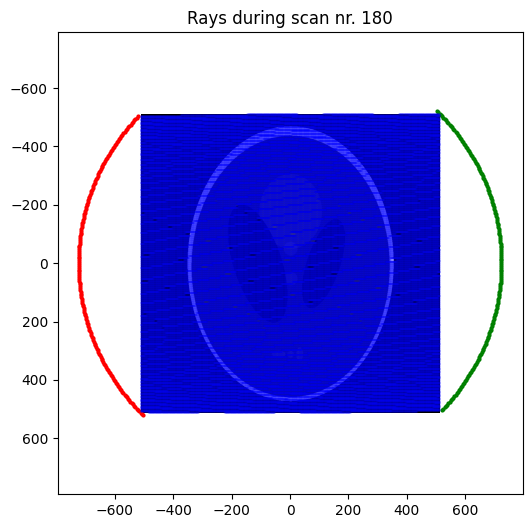

In [78]:
scan_rays = calculate_scan_rays(
        filename, scans_count, alfa_step, detectors_count, detectors_angular_aperture, has_to_show_intermediate_steps
    )

In [79]:
sinogram = calculate_sinogram(filename, scan_rays, has_to_use_sinogram_filter, has_to_show_intermediate_steps)
if has_to_show_intermediate_steps:
    clear_output(wait=True)
    ipywidgets.interact(show_sinogram
                        , sinogram = ipywidgets.fixed(sinogram) 
                        , scan = ipywidgets.IntSlider(min=1, max=scans_count))

interactive(children=(IntSlider(value=1, description='scan', max=180, min=1), Output()), _dom_classes=('widget…

In [ ]:
image_data = make_image(filename, scan_rays, sinogram, has_to_show_intermediate_steps)
if has_to_show_intermediate_steps:
    clear_output(wait=True)
    ipywidgets.interact(show_image
                        , images = ipywidgets.fixed(image_data) 
                        , scan = ipywidgets.IntSlider(min=1, max=scans_count))
else:
    plt.figure(figsize=(6,6))
    plt.imshow(image_data, cmap="gray")
    plt.title(f"Final image after {scans_count} scans")
    clear_output(wait=True)
    plt.show()

interactive(children=(IntSlider(value=1, description='scan', max=180, min=1), Output()), _dom_classes=('widget…

In [ ]:

def load_bitmap(filename: str) -> ImageFile:
    image = Image.open("./obrazy/" + filename)
    return image
    
def get_line_pixels(start, end):
    # d0, d1 = np.diff([start,end], axis=0)[0]
    # if start[0] == end[0] and start[1] == end[1]:
    #     return (np.array([int(start[0])]), np.array([int(start[1])]))
    d0 = end[0] - start[0] 
    d1 = end[1] - start[1] 
    if np.abs(d0) > np.abs(d1):
        x = np.arange(start[0], end[0] + np.sign(d0), np.sign(d0), dtype=np.int32)
        n = len(x)
        y = np.linspace(start[1], end[1], n, endpoint=True, dtype=np.int32)
        return (x,y)
    else:
        y = np.arange(start[1], end[1] + np.sign(d1), np.sign(d1), dtype=np.int32)
        n = len(y)
        x = np.linspace(start[0], end[0], n, endpoint=True, dtype=np.int32)
        return (x,y)

def simulateComputedTomographyScan(
    image_filename: str,
    scans_count: int,
    alfa_step: float,
    detectors_count: int,
    detectors_angular_aperture: float,
    has_to_use_sinogram_filter: bool = True,
    has_to_show_intermediate_steps: bool = False
):
    # Load input image 
    image = load_bitmap(image_filename)
    image.load()
    image_size = image.size
    image_width, image_height = image_size
    image_pixels = np.asarray(image, dtype=np.float64)
    image_pixels = image_pixels.mean(axis=-1)
    image.close()

    # Inscribe image in circle ( center of circle is center of image )
    diagonal_length = sqrt(pow(image_width, 2) + pow(image_height, 2))
    radius = diagonal_length / 2

    # Calculate position of pixel (0,0) of image in a
    image_start_x = -image_width // 2
    image_start_y = -image_height // 2
    image_start = np.array([image_start_x, image_start_y])

    # Calculate positions of detectors and emitters on circle
    # All emitters and detectors positions set to (radius, radius)
    emitter_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )
    detector_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )

    # All emitters angles set to 0 rad
    emitter_angles = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # All detectors angles set to pi rad
    detector_angles = np.full((scans_count, detectors_count), pi, dtype=np.float64)

    # Angle differences between scans
    scan_start_angles = np.arange(
        0, scans_count * alfa_step, alfa_step, dtype=np.float64
    )

    # Update emitters and detectors angles to include difference in angle between scans
    emitter_angles += scan_start_angles[:, np.newaxis]
    detector_angles += scan_start_angles[:, np.newaxis]

    # Angle differences between detectors/emitters
    detector_angle_differences = np.linspace(
        -detectors_angular_aperture / 2,
        detectors_angular_aperture / 2,
        detectors_count,
        dtype=np.float64,
    )

    # Update emitters and detectors angles to include difference in angle between detectors/emitters
    emitter_angles -= detector_angle_differences
    detector_angles += detector_angle_differences

    # Calculate coordinates of emitters
    emitter_positions_x = np.cos(emitter_angles)
    emitter_positions_y = np.sin(emitter_angles)
    emitter_positions_xy = np.stack(
        (emitter_positions_x, emitter_positions_y), axis=-1, dtype=np.float64
    )
    emitter_positions *= emitter_positions_xy

    # Calculate coordinates of detectors
    detector_positions_x = np.cos(detector_angles)
    detector_positions_y = np.sin(detector_angles)
    detector_positions_xy = np.stack(
        (detector_positions_x, detector_positions_y), axis=-1, dtype=np.float64
    )
    detector_positions *= detector_positions_xy

    # Shift coordinates to match with image
    emitter_positions -= image_start[np.newaxis, np.newaxis, :]
    detector_positions -= image_start[np.newaxis, np.newaxis, :]

    # Calculate last indexes of image
    max_x = image_width - 1 
    max_y = image_height - 1 
    
    # Calculate standard forms of linear equation for all rays between detectors and emitters ( Ax + By = C )
    A_values = detector_positions[:,:,1] - emitter_positions[:,:,1]
    B_values = emitter_positions[:,:,0] - detector_positions[:,:,0]
    C_values = A_values * emitter_positions[:,:,0] + B_values * emitter_positions[:,:,1]

    # Calculate intersections of rays and image boundaries or -1 if lines are parallel
    # for x = 0 (left side of image)
    y1 = np.divide(C_values, 
                   B_values, 
                   out=np.full_like(C_values, -1), 
                   where=B_values!=0)
    # for x = max_x (right side of image)
    y2 = np.divide(C_values - (A_values * max_x), 
                   B_values, 
                   out=np.full_like(C_values, -1), 
                   where=B_values!=0)
    # for y = 0 (top side of image)
    x1 = np.divide(C_values, 
                   A_values, 
                   out=np.full_like(C_values, -1), 
                   where=A_values!=0)
    # for y = max_y (bottom side of image)
    x2 = np.divide(C_values - (B_values * max_y), 
                   A_values, 
                   out=np.full_like(C_values, -1), 
                   where=A_values!=0)
    
    # Get full coordinates of intersection points
    # for x = 0 (left side of image)
    intersections_1 = np.stack([np.zeros_like(y1),y1], axis=-1)
    # for x = max_x (right side of image)
    intersections_2 = np.stack([np.full_like(y2, max_x),y2], axis=-1)
    # for y = 0 (top side of image)
    intersections_3 = np.stack([x1,np.zeros_like(x1)], axis=-1)
    # for y = max_y (bottom side of image)
    intersections_4 = np.stack([x2,np.full_like(x2, max_y)], axis=-1)

    # Merge all intersections
    intersections = np.stack([intersections_1, intersections_2, intersections_3, intersections_4], axis=-2)

    # Check if intersection points are inside image
    # for x = 0 (left side of image)
    is_inside_image_1 = ((0 <= intersections_1[:,:,1]) & (intersections_1[:,:,1] <= max_y))
    # for x = max_x (right side of image)
    is_inside_image_2 = ((0 <= intersections_2[:,:,1]) & (intersections_2[:,:,1] <= max_y))
    # for y = 0 (top side of image)
    is_inside_image_3 = ((0 < intersections_3[:,:,0]) & (intersections_3[:,:,0] < max_x))
    # for y = max_y (bottom side of image)
    is_inside_image_4 = ((0 < intersections_4[:,:,0]) & (intersections_4[:,:,0] < max_x))
    
    # Merge all checks
    is_inside_image = np.stack([is_inside_image_1, is_inside_image_2, is_inside_image_3, is_inside_image_4], axis=-1)


    all_scans_rays = np.empty((scans_count, detectors_count), dtype=np.object_)
    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):

            current_intersections = intersections[scan_number, detector_number]
            current_is_inside_image = is_inside_image[scan_number, detector_number]

            # Find which intersections are correct
            end_points = current_intersections[current_is_inside_image]

            if end_points.shape[0] == 0:
                # If no intersections are correct then ray is entirely outside image
                all_scans_rays[scan_number][detector_number] = tuple(([], []))
                continue

            if end_points.shape[0] == 1:
                # If only one intersection is correct then ray pass only through 1 pixel
                x, y = end_points[0]
                all_scans_rays[scan_number][detector_number] = tuple(([int(x)], [int(y)]))
                continue

            # Calculate pixels of image that are passed through between given end_points
            pixels_coords = get_line_pixels(end_points[0], end_points[1])
            all_scans_rays[scan_number][detector_number] = pixels_coords            

        # Display optional rays image
        if has_to_show_intermediate_steps:
            plt.figure(figsize=(6, 6))
            plt.axis("equal")
            plt.xlim((-floor(radius * 1.1)-image_start_x, ceil(radius * 1.1)-image_start_x))
            plt.ylim((ceil(radius * 1.1)-image_start_y, -floor(radius * 1.1)-image_start_x))
            x, y = zip(*(emitter_positions[scan_number]))
            plt.plot(x, y, "ro", markersize=2)
            x, y = zip(*(detector_positions[scan_number]))
            plt.plot(x, y, "go", markersize=2)
            all_ray_pixels_x = []
            all_ray_pixels_y = []
            for ray in all_scans_rays[scan_number]:
                x, y = ray
                all_ray_pixels_x.extend(np.array(x))
                all_ray_pixels_y.extend(np.array(y))
            x, y = all_ray_pixels_x, all_ray_pixels_y
            plt.plot(x, y, "bo", markersize=1, alpha=0.1)
            plt.imshow(
                plt.imread(f"obrazy/{image_filename}"),
                extent=(
                    0,
                    image_width,
                    image_height,
                    0,
                ),
            )
            plt.title(f"Rays during scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()
    
    # Create matrix for sinogram data
    sinogram = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # Create kernel used for filtering if needed
    if has_to_use_sinogram_filter:
        kernel = np.zeros(21)
        kernel[10] = 1
        numerator = -4/(pi**2)
        for k in range(1,11,2):
            kernel_value = (numerator)/(k**2)
            kernel[k+10] = kernel_value
            kernel[-k+10] = kernel_value

    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):
            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                sinogram[scan_number, detector_number] = 0
                continue

            # Calculate average of pixels passed by ray
            sinogram[scan_number, detector_number] = np.mean(image_pixels[current_scan_ray])
            
        # Calculate convolution of sinogram and kernel
        if has_to_use_sinogram_filter:
            sinogram[scan_number] = np.convolve(sinogram[scan_number], kernel, mode="same")

        # Display optional sinogram image
        if has_to_show_intermediate_steps:
            plt.figure(figsize=(6,6))
            plt.imshow(sinogram, cmap="gray")
            plt.title(f"Sinogram after scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()

    # Create matrix for image data
    image_data = np.zeros(image_size)

    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):
            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                continue

            # Add value from sinogram to all pixels passed by ray
            image_data[current_scan_ray] += sinogram[scan_number, detector_number]

        if has_to_show_intermediate_steps:
            plt.figure(figsize=(6,6))
            plt.imshow(image_data, cmap="gray")
            plt.title(f"Image after scan nr. {scan_number+1}")
            clear_output(wait=True)
            plt.show()

def simulateComputedTomographyScan1(
    image_filename: str,
    scans_count: int,
    alfa_step: float,
    detectors_count: int,
    detectors_angular_aperture: float,
    has_to_use_sinogram_filter: bool = True,
    has_to_show_intermediate_steps: bool = False
):
    # Load input image 
    image = load_bitmap(image_filename)
    image.load()
    image_size = image.size
    image_width, image_height = image_size
    image_pixels = np.asarray(image, dtype=np.float64)
    image_pixels = image_pixels.mean(axis=-1)
    image.close()

    # Inscribe image in circle ( center of circle is center of image )
    diagonal_length = sqrt(pow(image_width, 2) + pow(image_height, 2))
    radius = diagonal_length / 2

    # Calculate position of pixel (0,0) of image in a
    image_start_x = -image_width // 2
    image_start_y = -image_height // 2
    image_start = np.array([image_start_x, image_start_y])

    # Calculate positions of detectors and emitters on circle
    # All emitters and detectors positions set to (radius, radius)
    emitter_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )
    detector_positions = np.full(
        (scans_count, detectors_count, 2), radius, dtype=np.float64
    )

    # All emitters angles set to 0 rad
    emitter_angles = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # All detectors angles set to pi rad
    detector_angles = np.full((scans_count, detectors_count), pi, dtype=np.float64)

    # Angle differences between scans
    scan_start_angles = np.arange(
        0, scans_count * alfa_step, alfa_step, dtype=np.float64
    )

    # Update emitters and detectors angles to include difference in angle between scans
    emitter_angles += scan_start_angles[:, np.newaxis]
    detector_angles += scan_start_angles[:, np.newaxis]

    # Angle differences between detectors/emitters
    detector_angle_differences = np.linspace(
        -detectors_angular_aperture / 2,
        detectors_angular_aperture / 2,
        detectors_count,
        dtype=np.float64,
    )

    # Update emitters and detectors angles to include difference in angle between detectors/emitters
    emitter_angles -= detector_angle_differences
    detector_angles += detector_angle_differences

    # Calculate coordinates of emitters
    emitter_positions_x = np.cos(emitter_angles)
    emitter_positions_y = np.sin(emitter_angles)
    emitter_positions_xy = np.stack(
        (emitter_positions_x, emitter_positions_y), axis=-1, dtype=np.float64
    )
    emitter_positions *= emitter_positions_xy

    # Calculate coordinates of detectors
    detector_positions_x = np.cos(detector_angles)
    detector_positions_y = np.sin(detector_angles)
    detector_positions_xy = np.stack(
        (detector_positions_x, detector_positions_y), axis=-1, dtype=np.float64
    )
    detector_positions *= detector_positions_xy

    # Shift coordinates to match with image
    emitter_positions -= image_start[np.newaxis, np.newaxis, :]
    detector_positions -= image_start[np.newaxis, np.newaxis, :]

    # Calculate last indexes of image
    max_x = image_width - 1 
    max_y = image_height - 1 
    
    # Calculate standard forms of linear equation for all rays between detectors and emitters ( Ax + By = C )
    A_values = detector_positions[:,:,1] - emitter_positions[:,:,1]
    B_values = emitter_positions[:,:,0] - detector_positions[:,:,0]
    C_values = A_values * emitter_positions[:,:,0] + B_values * emitter_positions[:,:,1]

    # Calculate intersections of rays and image boundaries or -1 if lines are parallel
    # for x = 0 (left side of image)
    y1 = np.divide(C_values, 
                   B_values, 
                   out=np.full_like(C_values, -1), 
                   where=B_values!=0)
    # for x = max_x (right side of image)
    y2 = np.divide(C_values - (A_values * max_x), 
                   B_values, 
                   out=np.full_like(C_values, -1), 
                   where=B_values!=0)
    # for y = 0 (top side of image)
    x1 = np.divide(C_values, 
                   A_values, 
                   out=np.full_like(C_values, -1), 
                   where=A_values!=0)
    # for y = max_y (bottom side of image)
    x2 = np.divide(C_values - (B_values * max_y), 
                   A_values, 
                   out=np.full_like(C_values, -1), 
                   where=A_values!=0)
    
    # Get full coordinates of intersection points
    # for x = 0 (left side of image)
    intersections_1 = np.stack([np.zeros_like(y1),y1], axis=-1)
    # for x = max_x (right side of image)
    intersections_2 = np.stack([np.full_like(y2, max_x),y2], axis=-1)
    # for y = 0 (top side of image)
    intersections_3 = np.stack([x1,np.zeros_like(x1)], axis=-1)
    # for y = max_y (bottom side of image)
    intersections_4 = np.stack([x2,np.full_like(x2, max_y)], axis=-1)

    # Merge all intersections
    intersections = np.stack([intersections_1, intersections_2, intersections_3, intersections_4], axis=-2)

    # Check if intersection points are inside image
    # for x = 0 (left side of image)
    is_inside_image_1 = ((0 <= intersections_1[:,:,1]) & (intersections_1[:,:,1] <= max_y))
    # for x = max_x (right side of image)
    is_inside_image_2 = ((0 <= intersections_2[:,:,1]) & (intersections_2[:,:,1] <= max_y))
    # for y = 0 (top side of image)
    is_inside_image_3 = ((0 < intersections_3[:,:,0]) & (intersections_3[:,:,0] < max_x))
    # for y = max_y (bottom side of image)
    is_inside_image_4 = ((0 < intersections_4[:,:,0]) & (intersections_4[:,:,0] < max_x))
    
    # Merge all checks
    is_inside_image = np.stack([is_inside_image_1, is_inside_image_2, is_inside_image_3, is_inside_image_4], axis=-1)

    # Create matrix of ray pixels
    all_scans_rays = np.empty((scans_count, detectors_count), dtype=np.object_)
    
    # Create matrix for sinogram data
    sinogram = np.zeros((scans_count, detectors_count), dtype=np.float64)

    # Create kernel used for filtering if needed
    if has_to_use_sinogram_filter:
        kernel = np.zeros(21)
        kernel[10] = 1
        numerator = -4/(pi**2)
        for k in range(1,11,2):
            kernel_value = (numerator)/(k**2)
            kernel[k+10] = kernel_value
            kernel[-k+10] = kernel_value
            
    # Create matrix for image data
    image_data = np.zeros(image_size)

    # Create array of created images
    images = np.empty((scans_count, image_height, image_width))

    for scan_number in range(scans_count):
        for detector_number in range(detectors_count):

            current_intersections = intersections[scan_number, detector_number]
            current_is_inside_image = is_inside_image[scan_number, detector_number]

            # Find which intersections are correct
            end_points = current_intersections[current_is_inside_image]

            if end_points.shape[0] == 0:
                # If no intersections are correct then ray is entirely outside image
                all_scans_rays[scan_number][detector_number] = tuple(([], []))
                continue

            if end_points.shape[0] == 1:
                # If only one intersection is correct then ray pass only through 1 pixel
                x, y = end_points[0]
                all_scans_rays[scan_number][detector_number] = tuple(([int(x)], [int(y)]))
                continue

            # Calculate pixels of image that are passed through between given end_points
            pixels_coords = get_line_pixels(end_points[0], end_points[1])
            all_scans_rays[scan_number, detector_number] = pixels_coords

            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                sinogram[scan_number, detector_number] = 0
                continue

            # Calculate average of pixels passed by ray
            sinogram[scan_number, detector_number] = np.mean(image_pixels[current_scan_ray])
        
        # Calculate convolution of sinogram and kernel if needed
        if has_to_use_sinogram_filter:
            sinogram[scan_number] = np.convolve(sinogram[scan_number], kernel, mode="same")

        for detector_number in range(detectors_count):
            current_scan_ray = all_scans_rays[scan_number, detector_number]
            # Check if ray passed through any image pixels
            if len(current_scan_ray[0]) == 0:
                continue

            # Add value from sinogram to all pixels passed by ray
            image_data[current_scan_ray] += sinogram[scan_number, detector_number]

        # Save image data
        images[scan_number] = image_data.copy()

        # Display optional intermediate stages
        if has_to_show_intermediate_steps:
            fig, axes = plt.subplots(1,3,figsize=(18, 6))
            axes[0].axis("equal")
            axes[0].set_xlim((-floor(radius * 1.1)-image_start_x, ceil(radius * 1.1)-image_start_x))
            axes[0].set_ylim((ceil(radius * 1.1)-image_start_y, -floor(radius * 1.1)-image_start_x))
            x, y = zip(*(emitter_positions[scan_number]))
            axes[0].plot(x, y, "ro", markersize=2)
            x, y = zip(*(detector_positions[scan_number]))
            axes[0].plot(x, y, "go", markersize=2)
            all_ray_pixels_x = []
            all_ray_pixels_y = []
            for ray in all_scans_rays[scan_number]:
                x, y = ray
                all_ray_pixels_x.extend(np.array(x))
                all_ray_pixels_y.extend(np.array(y))
            x, y = all_ray_pixels_x, all_ray_pixels_y
            axes[0].plot(x, y, "bo", markersize=1, alpha=0.1)
            axes[0].imshow(
                plt.imread(f"obrazy/{image_filename}"),
                extent=(
                    0,
                    image_width,
                    image_height,
                    0,
                ),
            )
            axes[0].set_title(f"Rays during scan nr. {scan_number+1}")

            axes[1].imshow(sinogram, cmap="gray")
            axes[1].set_title(f"Sinogram after scan nr. {scan_number+1}")
            
            axes[2].imshow(image_data, cmap="gray")
            axes[2].set_title(f"Image after scan nr. {scan_number+1}")

            clear_output(wait=True)
            # plt.tight_layout()
            plt.show()

    states = (emitter_positions, detector_positions, all_scans_rays, sinogram, images)

    showStateAfterScan(image_filename, states, scans_count)

    return states

def showStateAfterScan(image_filename, states, scan):
    emitter_positions, detector_positions, all_scans_rays, sinogram, images = states
    
    image_size = images[0].shape
    image_width, image_height = image_size
    diagonal_length = sqrt(pow(image_width, 2) + pow(image_height, 2))
    radius = diagonal_length / 2

    # Calculate position of pixel (0,0) of image in a
    image_start_x = -image_width // 2
    image_start_y = -image_height // 2

    fig, axes = plt.subplots(1,3,figsize=(18, 6))
    axes[0].axis("equal")
    axes[0].set_xlim((-floor(radius * 1.1)-image_start_x, ceil(radius * 1.1)-image_start_x))
    axes[0].set_ylim((ceil(radius * 1.1)-image_start_y, -floor(radius * 1.1)-image_start_x))
    x, y = zip(*(emitter_positions[scan-1]))
    axes[0].plot(x, y, "ro", markersize=2)
    x, y = zip(*(detector_positions[scan-1]))
    axes[0].plot(x, y, "go", markersize=2)
    all_ray_pixels_x = []
    all_ray_pixels_y = []
    for ray in all_scans_rays[scan-1]:
        x, y = ray
        all_ray_pixels_x.extend(np.array(x))
        all_ray_pixels_y.extend(np.array(y))
    x, y = all_ray_pixels_x, all_ray_pixels_y
    axes[0].plot(x, y, "bo", markersize=1, alpha=0.1)
    axes[0].imshow(
        plt.imread(f"obrazy/{image_filename}"),
        extent=(
            0,
            image_width,
            image_height,
            0,
        ),
    )
    axes[0].set_title(f"Rays during scan nr. {scan}")

    sinogram_after_n_scan = np.zeros_like(sinogram)
    sinogram_after_n_scan[:scan] = sinogram[:scan] 
    axes[1].imshow(sinogram_after_n_scan, cmap="gray")
    axes[1].set_title(f"Sinogram after scan nr. {scan}")
    
    axes[2].imshow(images[scan-1], cmap="gray")
    axes[2].set_title(f"Image after scan nr. {scan}")

    clear_output(wait=True)
    plt.show()


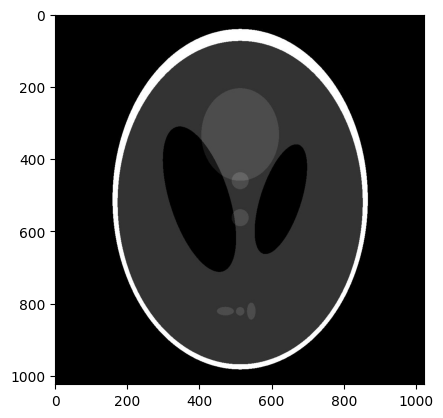

In [50]:
# filename = "Kropka.jpg"
filename = "Shepp_logan.jpg"

scans_count = 180
# scans_count = 90

alfa_step = pi / scans_count

detectors_count = 180
# detectors_count = 160

detectors_angular_aperture = 0.5 * pi

has_to_use_sinogram_filter = True
has_to_show_intermediate_steps = True

image = load_bitmap(filename)
plt.imshow(image)
image.close()

In [ ]:
simulateComputedTomographyScan(filename, scans_count, alfa_step, detectors_count, detectors_angular_aperture, has_to_use_sinogram_filter, has_to_show_intermediate_steps)

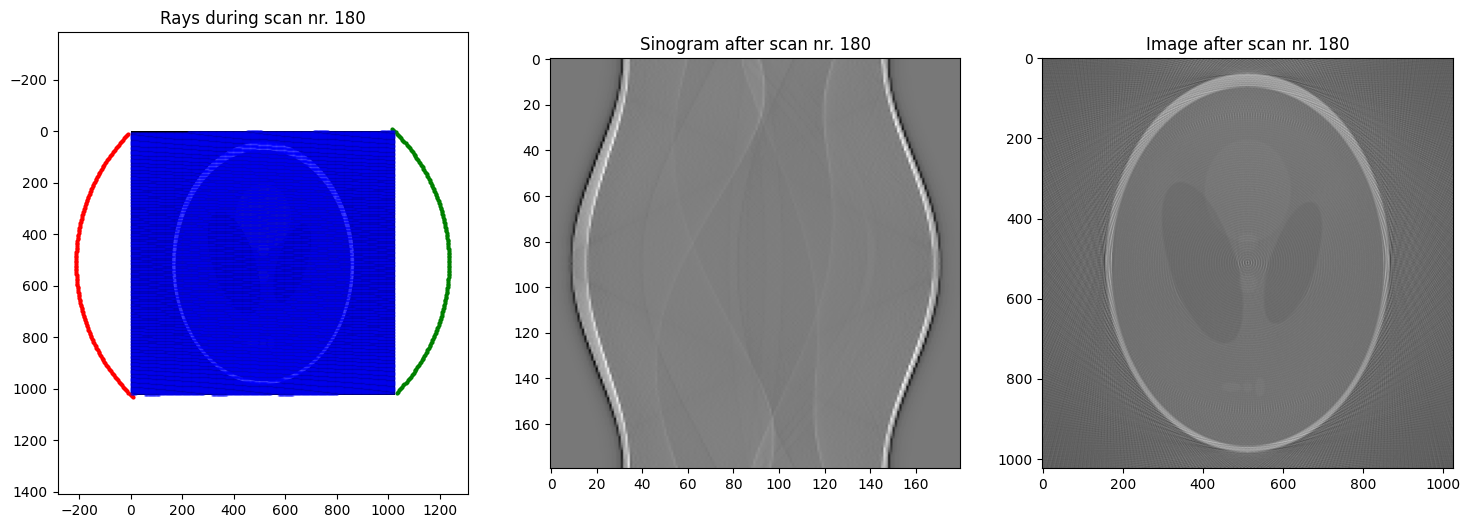

In [46]:
states = simulateComputedTomographyScan1(filename, scans_count, alfa_step, detectors_count, detectors_angular_aperture, has_to_use_sinogram_filter, not has_to_show_intermediate_steps)

In [51]:
ipywidgets.interact(showStateAfterScan
                    , image_filename=ipywidgets.fixed(filename)
                    , states = ipywidgets.fixed(states) 
                    , scan = ipywidgets.IntSlider(min=1, max=scans_count))

interactive(children=(IntSlider(value=1, description='scan', max=180, min=1), Output()), _dom_classes=('widget…

<function __main__.showStateAfterScan(image_filename, states, scan)>